# Automated bacterial strip segmentation

This is an image segmentation algorithm using basic functions from OpenCV. The task is to crop bacterial test trips from image. 

In [1]:
# Import all necesary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Some function definition:
def plthist(image):    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([image],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    return plt.show()

def crop_center(image,cropx,cropy):
    y,x = image.shape[0:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return image[starty:starty+cropy,startx:startx+cropx,:]

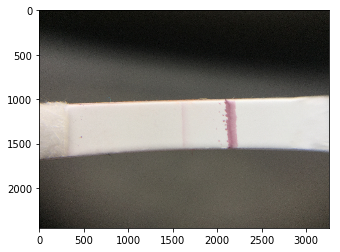

In [19]:
# Read and display the image
input_dir = "data_input"
filename = "IMG_3112.JPG"
image_path = os.path.join(input_dir,filename)
original = cv2.imread(image_path)                               
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

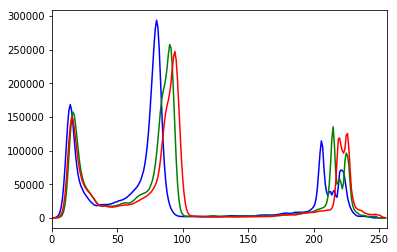

In [4]:
# First check historgram of image
plthist(original)

## Part 1: Bacterial Strip Segmentation

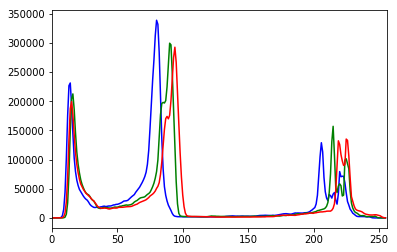

In [5]:
#Check histogram for Gaussian blur
blur = cv2.GaussianBlur(original,(5,5),0)
plthist(blur)

We see that pixels are broadly divided into 2 groups: <br>
One group has value in the range of 50-100 and other group has value outside it. Since 2 clear groups seem to exist in the image, first lets try **OTSU** thresholding in this image to see what kind of mask it can generate

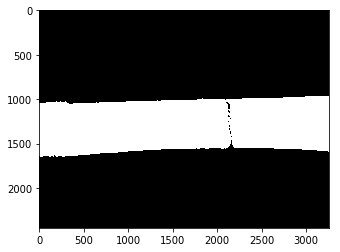

In [6]:
# Otsu Thresholding with Gaussian Blur
blur1 = cv2.GaussianBlur(original,(7,7),0)
bw = cv2.cvtColor(blur1, cv2.COLOR_BGR2GRAY)
ret, otsu_th = cv2.threshold(bw,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu_th, cmap='gray')

Here we see that the foreground pixels have gaps in them. To fill up this gap we can use Morhological operations like Area closing which is applicable in this case as seen from image.

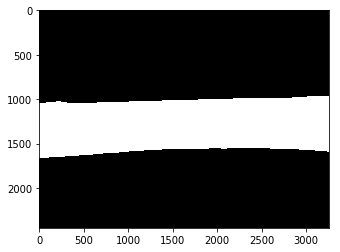

In [7]:
# Area Closing
kernel = np.ones((120,120),'uint8')
closing = cv2.morphologyEx(otsu_th, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

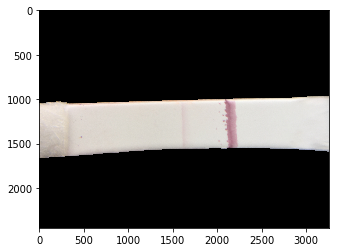

In [8]:
# Prepare segmented image
mask_strip = cv2.merge((closing,closing,closing))
strip= cv2.bitwise_and(original, mask_strip)
plt.imshow(cv2.cvtColor(strip, cv2.COLOR_BGR2RGB))

## Part 2: Autocrop for Bacterial Strip

We cropping we will use numpy indexing. We create a boolean two boolean mask and do their multiplication to come to the resultant image.

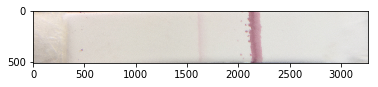

In [9]:
tol =0
mask = strip[:,:,0]>tol
ch1 = strip[:,:,0][np.ix_(mask.all(1),mask.any(0))]
ch2 = strip[:,:,1][np.ix_(mask.all(1),mask.any(0))]
ch3 = strip[:,:,2][np.ix_(mask.all(1),mask.any(0))]
final = cv2.merge((ch1,ch2,ch3))
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

## Part 3: Cropping only the bacterial stain protion from the strip

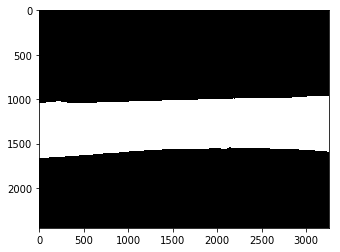

In [10]:
# Check Otsu Thresholding
gray = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
ret, otsu_th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu_th2, cmap='gray')

We see that Otsu Thresholding does not yield any positive result. Lets see the HSV channel of the image

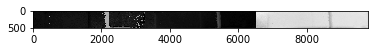

In [11]:
hsv = cv2.cvtColor(final, cv2.COLOR_BGR2HSV)
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]
hsv_split = np.concatenate((h,s,v), axis=1)
plt.imshow(hsv_split, cmap='gray')


Using HSV channel can give better results as we see that the central purple area is dintiguished in them. Also, as we see that the desired ROI is always in the center of the image, lets crop the image from center. 

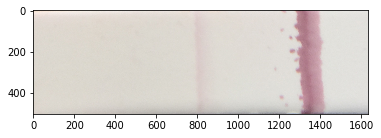

In [12]:
# Cropped Image
height, width = original.shape[0:2]
cropped = crop_center(final,width//2,height)
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

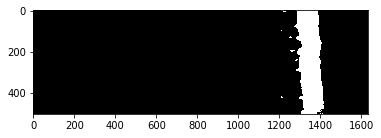

In [13]:
# hsv for cropped image
hsv = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# Otsu thresholding on hue channel
ret, hue = cv2.threshold(h,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu thresholding on sat channel
ret, sat = cv2.threshold(s,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

thresh = cv2.bitwise_and(sat,hue)
plt.imshow(thresh, cmap='gray')

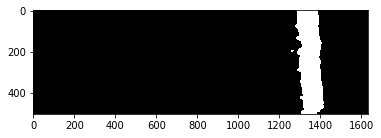

In [14]:
# Area opening on final thresh image
kernel = np.ones((9,9),'uint8')
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

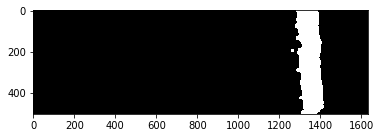

In [15]:
# A bit of dilation
kernel = np.ones((3,3),'uint8')
dilate = cv2.dilate(opening,kernel,iterations=1)
plt.imshow(dilate, cmap='gray')

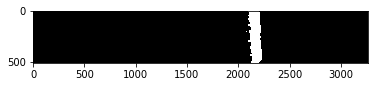

In [16]:
# Convert the image back to original shape
top = 0
left = width//4
constant= cv2.copyMakeBorder(dilate,top,top,left,left,cv2.BORDER_CONSTANT,0) 
plt.imshow(constant, cmap='gray')

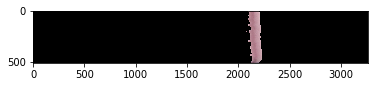

In [17]:
# Preparing segmented image
mask = cv2.merge((constant,constant,constant))
bacteria= cv2.bitwise_and(final, mask)
plt.imshow(cv2.cvtColor(bacteria, cv2.COLOR_BGR2RGB))